In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../artifacts/preprocessed_comment_dataset.csv',keep_default_na=False)

In [3]:
data.head()

,id,comment,label,label_encoded
0,1,මෑන් අයිඩීක් ඔබේ පරිගණක පිරිවිතර මොනවාද ඔබ නැව...,BaseballBat,0
1,2,සහෝදරයා ඔබට වෙව්ට කළේ කුමක්ද,BaseballBat,0
2,3,දුප්පත් විල්ලෙයි,BaseballBat,0
3,4,බ්රෝ කුරිරු යක්ෂයා පත් විය,BaseballBat,0
4,5,සහෝදරයා තම මිතුරා අපයෝජනය කරයි,BaseballBat,0


#### Building Vacabulary

In [4]:
from collections import Counter

vocab = Counter()
for sentence in data['comment']:
    vocab.update(sentence.split())

tokens = [key for key in vocab if vocab[key] > 10]  # filter low-frequency words
print(f"Vocabulary size: {len(tokens)}")


Vocabulary size: 1779


In [5]:
len(vocab)

25121

In [6]:
def save_vocabulary(lines, filename):
    with open(filename, 'w', encoding="utf-8") as file:
        file.write('\n'.join(lines))

save_vocabulary(tokens, '../statics/model/vocabulary.txt')


In [7]:
data.shape

(14023, 4)

#### Divide dataset

In [8]:
from sklearn.model_selection import train_test_split

X = data['comment']
y = data['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


#### Vectorization

In [9]:
def vectorizer(ds, vocabulary):
    vectorized_lst = []
    for sentence in ds:
        sentence_lst = np.zeros(len(vocabulary))
        words = sentence.split()
        for i, word in enumerate(vocabulary):
            if word in words:
                sentence_lst[i] = 1
        vectorized_lst.append(sentence_lst)
    return np.array(vectorized_lst, dtype=np.float32)

vectorized_x_train = vectorizer(X_train, tokens)
vectorized_x_test = vectorizer(X_test, tokens)


In [13]:
vectorized_x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], shape=(11218, 1779), dtype=float32)

In [10]:
y_train.value_counts()

label_encoded
5    2160
0    2009
2    1916
3    1795
1    1749
4    1589
Name: count, dtype: int64

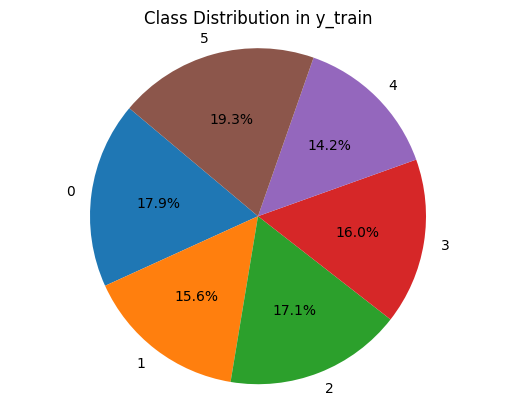

In [36]:
# Count class distribution
class_counts = y_train.value_counts().sort_index()

# Create pie chart
plt.pie(class_counts, labels=class_counts.index.astype(str), autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution in y_train")
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.show()


#### Handle Class Imbalance with SMOTE

In [14]:
!pip install imbalanced-learn

  Using cached scikit_learn-1.6.1-cp310-cp310-win_amd64.whl.metadata (15 kB)
Using cached scikit_learn-1.6.1-cp310-cp310-win_amd64.whl (11.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.0
    Uninstalling scikit-learn-1.7.0:
      Successfully uninstalled scikit-learn-1.7.0


  You can safely remove it manually.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
vectorized_x_train_smote, y_train_smote = smote.fit_resample(vectorized_x_train, y_train)   #create synthetic samples


In [38]:
y_train_smote.value_counts()

label_encoded
1    2160
5    2160
2    2160
0    2160
3    2160
4    2160
Name: count, dtype: int64

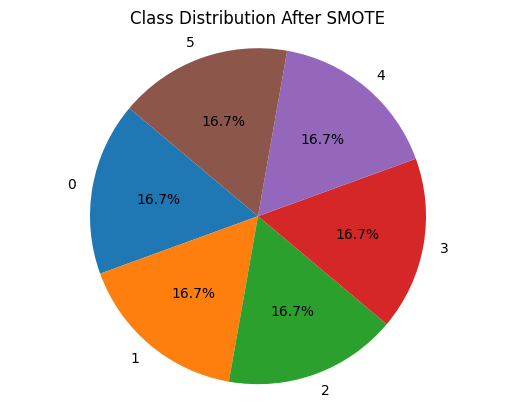

In [39]:
class_counts_after_smote = pd.Series(y_train_smote).value_counts().sort_index()

# Plot pie chart
plt.pie(class_counts_after_smote, 
        labels=class_counts_after_smote.index.astype(str), 
        autopct='%1.1f%%', 
        startangle=140)

plt.title("Class Distribution After SMOTE")
plt.axis('equal')  
plt.show()

#### Model Training and Evaluation

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [41]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    pr = round(precision_score(y_act, y_pred, average='weighted'), 3)
    rec = round(recall_score(y_act, y_pred, average='weighted'), 3)
    f1 = round(f1_score(y_act, y_pred, average='weighted'), 3)
    print(f'Training Scores:\n\tAccuracy = {acc}\n\tPrecision = {pr}\n\tRecall = {rec}\n\tF1-Score = {f1}')

def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    pr = round(precision_score(y_act, y_pred, average='weighted'), 3)
    rec = round(recall_score(y_act, y_pred, average='weighted'), 3)
    f1 = round(f1_score(y_act, y_pred, average='weighted'), 3)
    print(f'Testing Scores:\n\tAccuracy = {acc}\n\tPrecision = {pr}\n\tRecall = {rec}\n\tF1-Score = {f1}')


In [77]:
    pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### **Logistic Regression**

In [42]:
lr = LogisticRegression()
lr.fit(vectorized_x_train_smote, y_train_smote)

y_train_pred = lr.predict(vectorized_x_train_smote)
y_test_pred = lr.predict(vectorized_x_test)

training_scores(y_train_smote, y_train_pred)
validation_scores(y_test, y_test_pred)


Training Scores:
	Accuracy = 0.663
	Precision = 0.693
	Recall = 0.663
	F1-Score = 0.668
Testing Scores:
	Accuracy = 0.478
	Precision = 0.499
	Recall = 0.478
	F1-Score = 0.482


##### Classification Report 

In [43]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Refit encoder from original labels if needed
label_encoder = LabelEncoder()
label_encoder.fit(data['label'])  # Replace `data['label']` with the original label column if different

class_names = label_encoder.classes_

print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, digits=3, target_names=class_names))


Classification Report (Test Set):
                       precision    recall  f1-score   support

          BaseballBat      0.562     0.494     0.526       502
BombExplotionInPublic      0.540     0.481     0.508       437
            HitAndRun      0.522     0.415     0.463       479
     KillCowWithKnife      0.513     0.488     0.500       449
           LipKissing      0.326     0.563     0.413       398
                 None      0.505     0.448     0.475       540

             accuracy                          0.478      2805
            macro avg      0.495     0.481     0.481      2805
         weighted avg      0.499     0.478     0.482      2805



##### Confusion Matrix (with Heatmap)

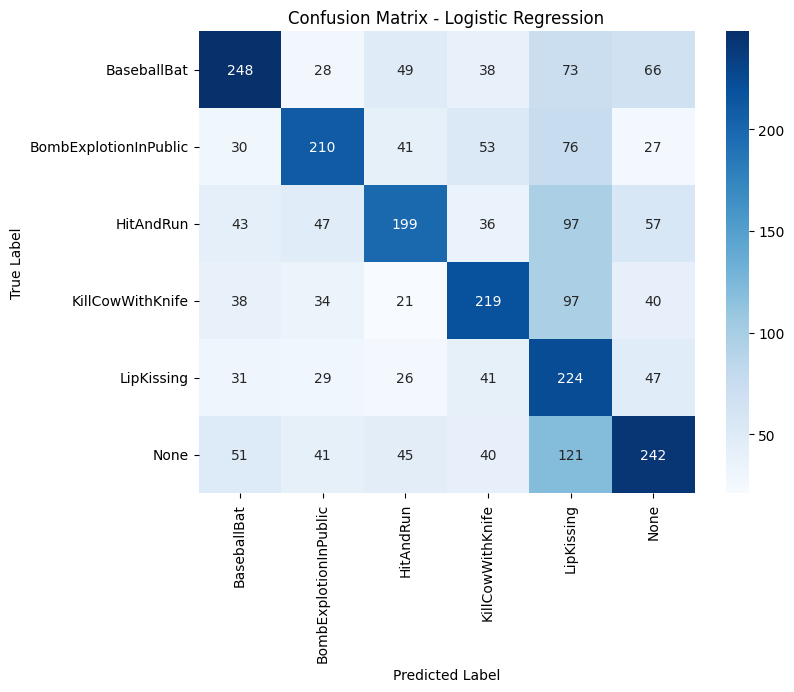

In [44]:
cm = confusion_matrix(y_test, y_test_pred)

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")  # Change title per model
plt.show()

#####  Bar Chart of Per-Class Accuracy

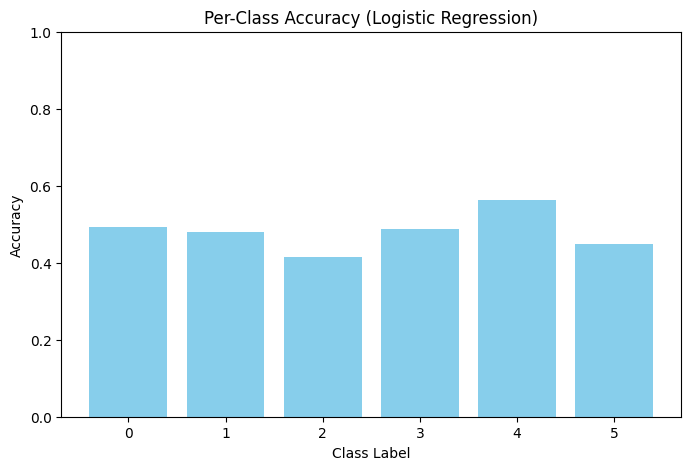

In [45]:
import numpy as np
unique_labels = np.unique(y_test)
per_class_accuracy = []

for label in unique_labels:
    idx = y_test == label
    acc = accuracy_score(y_test[idx], y_test_pred[idx])
    per_class_accuracy.append(acc)

# Plot
plt.figure(figsize=(8, 5))
plt.bar([str(lbl) for lbl in unique_labels], per_class_accuracy, color='skyblue')
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy (Logistic Regression)")
plt.ylim(0, 1)
plt.show()


### **Naive Bayes**

In [46]:
mnb = MultinomialNB()
mnb.fit(vectorized_x_train_smote, y_train_smote)

y_train_pred = mnb.predict(vectorized_x_train_smote)
y_test_pred = mnb.predict(vectorized_x_test)

training_scores(y_train_smote, y_train_pred)
validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.569
	Precision = 0.596
	Recall = 0.569
	F1-Score = 0.572
Testing Scores:
	Accuracy = 0.489
	Precision = 0.509
	Recall = 0.489
	F1-Score = 0.49


##### Classification Report

In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Refit encoder from original labels if needed
label_encoder = LabelEncoder()
label_encoder.fit(data['label'])  # Replace `data['label']` with the original label column if different

class_names = label_encoder.classes_

print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, digits=3, target_names=class_names))


Classification Report (Test Set):
                       precision    recall  f1-score   support

          BaseballBat      0.390     0.586     0.469       502
BombExplotionInPublic      0.559     0.497     0.526       437
            HitAndRun      0.582     0.443     0.503       479
     KillCowWithKnife      0.506     0.492     0.499       449
           LipKissing      0.438     0.523     0.477       398
                 None      0.567     0.407     0.474       540

             accuracy                          0.489      2805
            macro avg      0.507     0.491     0.491      2805
         weighted avg      0.509     0.489     0.490      2805



##### Confusion Matrix (with Heatmap)

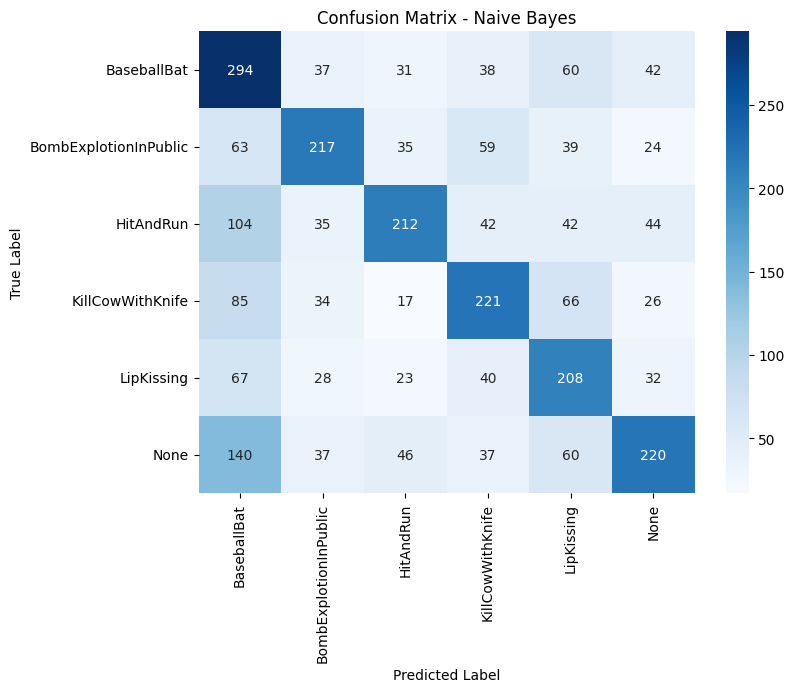

In [48]:
cm = confusion_matrix(y_test, y_test_pred)

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Naive Bayes")  # Change title per model
plt.show()

##### Bar Chart of Per-Class Accuracy

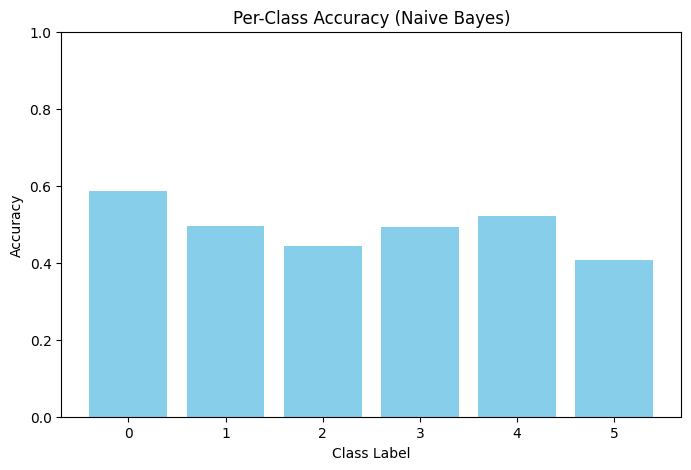

In [49]:
import numpy as np
unique_labels = np.unique(y_test)
per_class_accuracy = []

for label in unique_labels:
    idx = y_test == label
    acc = accuracy_score(y_test[idx], y_test_pred[idx])
    per_class_accuracy.append(acc)

# Plot
plt.figure(figsize=(8, 5))
plt.bar([str(lbl) for lbl in unique_labels], per_class_accuracy, color='skyblue')
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy (Naive Bayes)")
plt.ylim(0, 1)
plt.show()


### **Decision Tree**

In [50]:
dt = DecisionTreeClassifier()
dt.fit(vectorized_x_train_smote, y_train_smote)

y_train_pred = dt.predict(vectorized_x_train_smote)
y_test_pred = dt.predict(vectorized_x_test)

training_scores(y_train_smote, y_train_pred)
validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.882
	Precision = 0.901
	Recall = 0.882
	F1-Score = 0.886
Testing Scores:
	Accuracy = 0.38
	Precision = 0.399
	Recall = 0.38
	F1-Score = 0.383


##### Classification Report

In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Refit encoder from original labels if needed
label_encoder = LabelEncoder()
label_encoder.fit(data['label'])  # Replace `data['label']` with the original label column if different

class_names = label_encoder.classes_

print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, digits=3, target_names=class_names))


Classification Report (Test Set):
                       precision    recall  f1-score   support

          BaseballBat      0.421     0.400     0.410       502
BombExplotionInPublic      0.386     0.359     0.372       437
            HitAndRun      0.425     0.326     0.369       479
     KillCowWithKnife      0.409     0.414     0.412       449
           LipKissing      0.259     0.455     0.330       398
                 None      0.464     0.343     0.394       540

             accuracy                          0.380      2805
            macro avg      0.394     0.383     0.381      2805
         weighted avg      0.399     0.380     0.383      2805



##### Confusion Matrix (with Heatmap

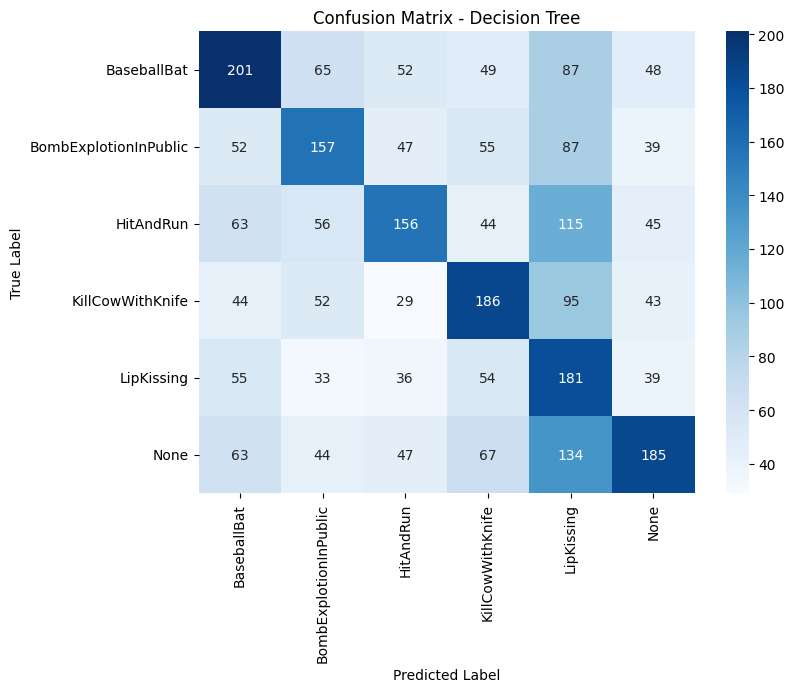

In [52]:
cm = confusion_matrix(y_test, y_test_pred)

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Decision Tree")  # Change title per model
plt.show()

##### Bar Chart of Per-Class Accuracy

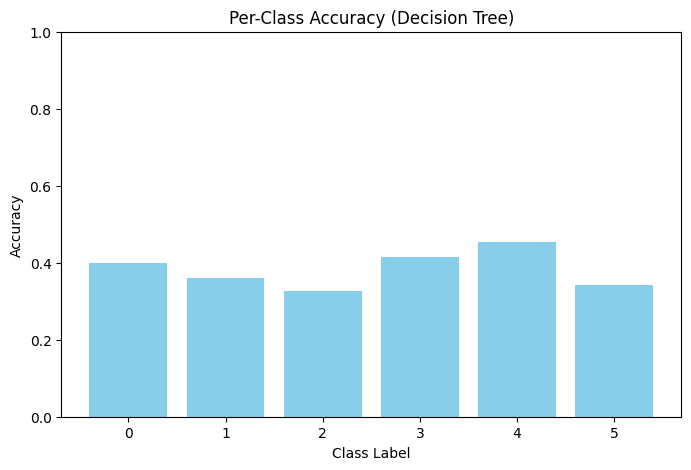

In [53]:
import numpy as np
unique_labels = np.unique(y_test)
per_class_accuracy = []

for label in unique_labels:
    idx = y_test == label
    acc = accuracy_score(y_test[idx], y_test_pred[idx])
    per_class_accuracy.append(acc)

# Plot
plt.figure(figsize=(8, 5))
plt.bar([str(lbl) for lbl in unique_labels], per_class_accuracy, color='skyblue')
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy (Decision Tree)")
plt.ylim(0, 1)
plt.show()

### **Random Forest**

In [54]:
rf = RandomForestClassifier()
rf.fit(vectorized_x_train_smote, y_train_smote)

y_train_pred = rf.predict(vectorized_x_train_smote)
y_test_pred = rf.predict(vectorized_x_test)

training_scores(y_train_smote, y_train_pred)
validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.882
	Precision = 0.903
	Recall = 0.882
	F1-Score = 0.886
Testing Scores:
	Accuracy = 0.441
	Precision = 0.46
	Recall = 0.441
	F1-Score = 0.443


##### Classification Report

In [55]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Refit encoder from original labels if needed
label_encoder = LabelEncoder()
label_encoder.fit(data['label'])  # Replace `data['label']` with the original label column if different

class_names = label_encoder.classes_

print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, digits=3, target_names=class_names))


Classification Report (Test Set):
                       precision    recall  f1-score   support

          BaseballBat      0.467     0.478     0.472       502
BombExplotionInPublic      0.511     0.414     0.458       437
            HitAndRun      0.481     0.361     0.412       479
     KillCowWithKnife      0.464     0.488     0.476       449
           LipKissing      0.308     0.520     0.387       398
                 None      0.502     0.402     0.447       540

             accuracy                          0.441      2805
            macro avg      0.455     0.444     0.442      2805
         weighted avg      0.460     0.441     0.443      2805



##### Confusion Matrix (with Heatmap

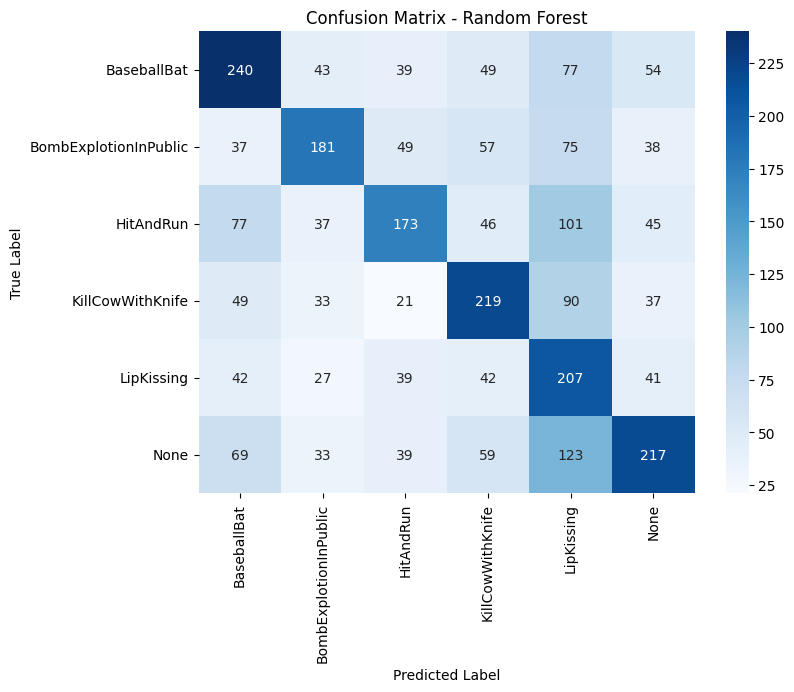

In [56]:
cm = confusion_matrix(y_test, y_test_pred)

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")  # Change title per model
plt.show()

##### Bar Chart of Per-Class Accuracy

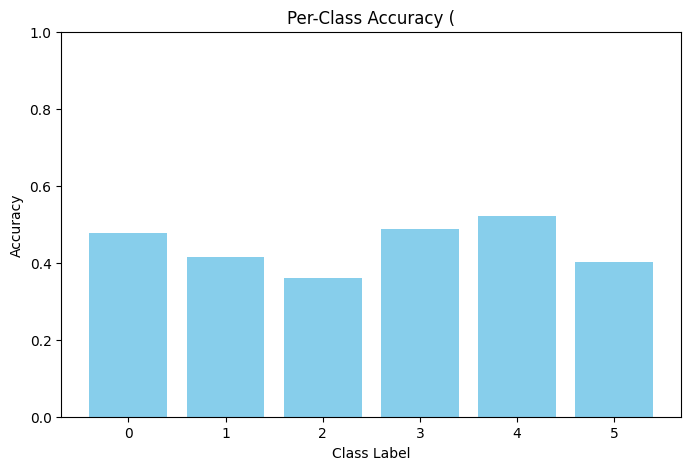

In [57]:
import numpy as np
unique_labels = np.unique(y_test)
per_class_accuracy = []

for label in unique_labels:
    idx = y_test == label
    acc = accuracy_score(y_test[idx], y_test_pred[idx])
    per_class_accuracy.append(acc)

# Plot
plt.figure(figsize=(8, 5))
plt.bar([str(lbl) for lbl in unique_labels], per_class_accuracy, color='skyblue')
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy (")
plt.ylim(0, 1)
plt.show()

### **Support Vector Machine**

In [58]:
svm = SVC()
svm.fit(vectorized_x_train_smote, y_train_smote)

y_train_pred = svm.predict(vectorized_x_train_smote)
y_test_pred = svm.predict(vectorized_x_test)

training_scores(y_train_smote, y_train_pred)
validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.734
	Precision = 0.795
	Recall = 0.734
	F1-Score = 0.745
Testing Scores:
	Accuracy = 0.446
	Precision = 0.477
	Recall = 0.446
	F1-Score = 0.452


##### Classification Report

In [59]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Refit encoder from original labels if needed
label_encoder = LabelEncoder()
label_encoder.fit(data['label'])  # Replace `data['label']` with the original label column if different

class_names = label_encoder.classes_

print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, digits=3, target_names=class_names))


Classification Report (Test Set):
                       precision    recall  f1-score   support

          BaseballBat      0.488     0.508     0.498       502
BombExplotionInPublic      0.503     0.435     0.466       437
            HitAndRun      0.486     0.376     0.424       479
     KillCowWithKnife      0.530     0.419     0.468       449
           LipKissing      0.281     0.538     0.369       398
                 None      0.540     0.417     0.470       540

             accuracy                          0.446      2805
            macro avg      0.471     0.449     0.449      2805
         weighted avg      0.477     0.446     0.452      2805



##### Confusion Matrix (with Heatmap

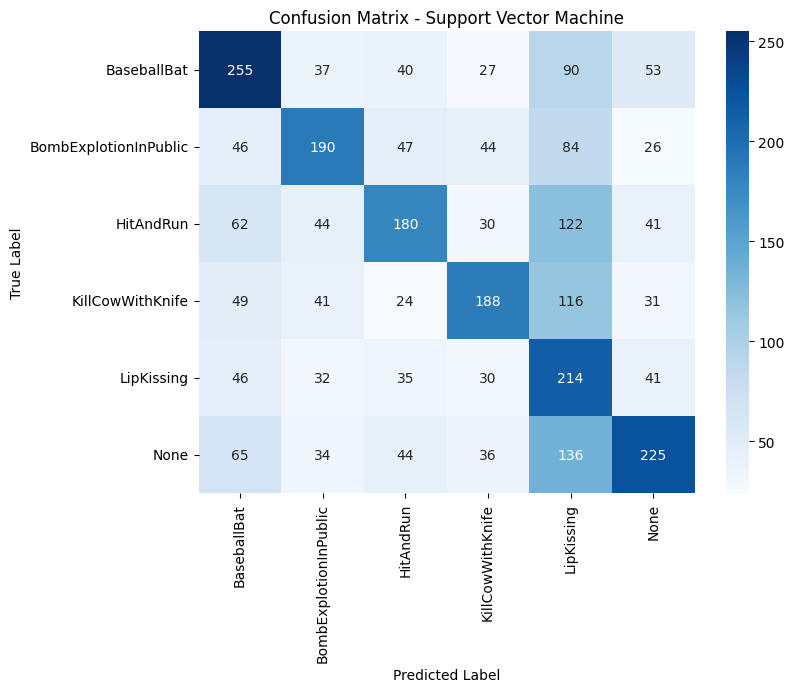

In [60]:
cm = confusion_matrix(y_test, y_test_pred)

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Support Vector Machine")  # Change title per model
plt.show()

##### Bar Chart of Per-Class Accuracy

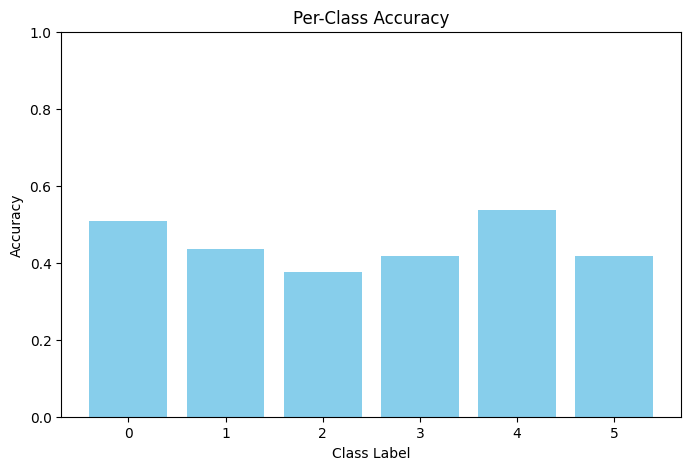

In [61]:
import numpy as np
unique_labels = np.unique(y_test)
per_class_accuracy = []

for label in unique_labels:
    idx = y_test == label
    acc = accuracy_score(y_test[idx], y_test_pred[idx])
    per_class_accuracy.append(acc)

# Plot
plt.figure(figsize=(8, 5))
plt.bar([str(lbl) for lbl in unique_labels], per_class_accuracy, color='skyblue')
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.ylim(0, 1)
plt.show()

In [102]:
# cm = confusion_matrix(y_test, y_test_pred)

# # Plot Heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#             xticklabels=label_encoder.classes_,
#             yticklabels=label_encoder.classes_)

# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix - Logistic Regression")  # Change title per model
# plt.show()